# making movies of the Sun

The Helioseismic and Magnetic Imager (HMI) on the Solar Dynamics Observatory takes full-disk continuum intensity, doppler velocity, and magnetic field maps of the solar surface. Here, we make a movie of the radial component of the vector magnetic field using a data product called [HMI Space-weather Active Region Patches](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) or SHARPs. SHARPs contain partial-disk patches of the continuum intensity, doppler velocity, and magnetic field maps. These patches encapsulate automatically-detected active regions that are tracked throughout their lifetime.

We can make movies in two different ways: 

- Use JSOC Exportdata to build a movie directly (but you are limited to its formats and colortables); see the ipython notebook within this same directory called `plot_swx_d3.ipynb` for an example.
- Make a movie from image data to create a customized movie of any size, colortable, or format. An example of this process is outlined below.

First, we import some modules:

In [1]:
import json, urllib, numpy as np, matplotlib, matplotlib.pylab as plt, requests
import matplotlib.animation as manimation
import drms
from datetime import datetime as dt_obj
from matplotlib.dates import *
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.animation as manimation
%matplotlib inline
%config InlineBackend.figure_format='retina'

We query the JSOC database, where all the SDO data are stored, using the JSON API to retrieve both keywords and the location of the SHARP image files. The [astropy](http://docs.astropy.org/en/stable/io/fits/index.html) library's  `fits.open()` call downloads the data. Here, we're querying for the $B_z$ component of the vector magnetic field (note the variable passed to the `Seg` keyword in the url below), although we can easily query for other data products (see table A.7 in [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) for segment name information). <br>

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.

In [2]:
import drms
c = drms.Client()

Then we query for the appropriate DRMS series for the keywords and segments of our choice:

In [3]:
keys, segments = c.query('hmi.sharp_cea_720s[185][2010.09.22_09:00_TAI-2010.09.22_15:00_TAI]', key='NOAA_ARS, T_REC, USFLUX, ERRVF', seg='Br, conf_disambig')

To convert the keyword `T_REC` into a datetime object, we can use the function below.

In [4]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [5]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

### Option 1: Use one of the `matplotlib.animation.Animation()` classes

This way, we can simply cycle through our data cube, grab each image, and export an mp4 file.  This is what the data look like, for one test image, using the seismic color table (you can also use the [SunPy color tables](http://docs.sunpy.org/en/stable/_modules/sunpy/cm/cm.html) for SDO images). The red and blue colors indicate negative and positive polarities, respectively.

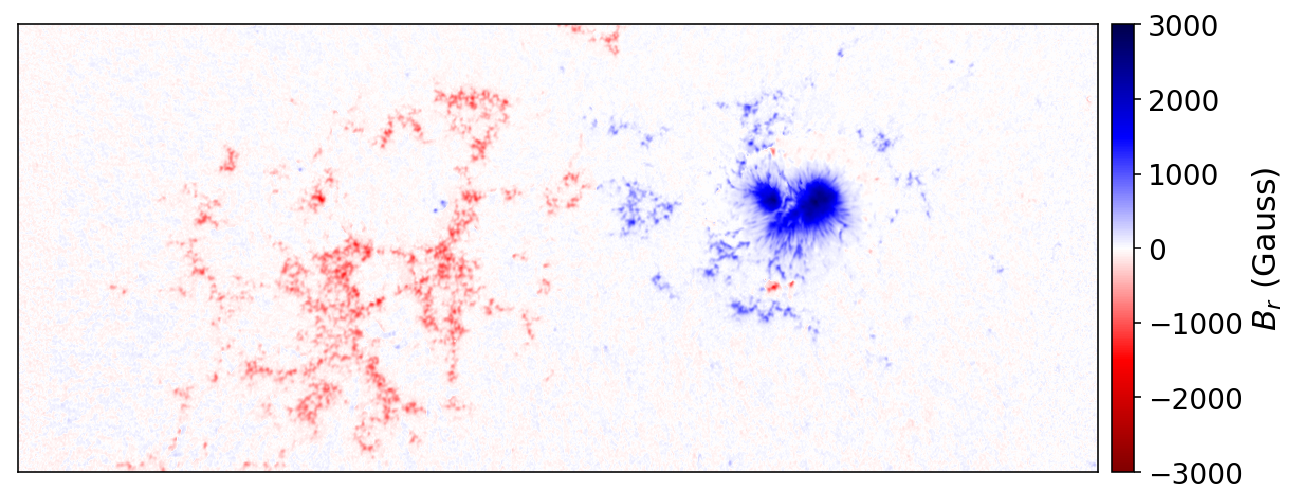

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
url = 'http://jsoc.stanford.edu' + segments.Br[10]  # add the jsoc.stanford.edu suffix to the segment name
photosphere_image = fits.open(url)                  # download the data
nx, ny = photosphere_image[1].data.shape
plt.imshow(photosphere_image[1].data,cmap='seismic_r',origin='lower',vmin=-3000,vmax=3000, extent=[0, ny, 0, nx], interpolation='nearest')
divider_cbar = make_axes_locatable(ax)
width_cbar = axes_size.AxesY(ax, aspect=0.05)
pad_cbar = axes_size.Fraction(0.6, width_cbar)
cax = divider_cbar.append_axes("right", size=width_cbar, pad=pad_cbar)
cax.tick_params(labelsize=14)
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$B_{r}$ (Gauss)', size=16)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
fig.set_size_inches(10,10)

Loop through all the images to create the movie:

In [7]:
%%capture
# dpi for retina display
# detect monitor dpi automatically here: http://www.infobyip.com/detectmonitordpi.php
my_dpi=192
nx, ny = photosphere_image[1].data.shape
fig = plt.figure(figsize=(nx/my_dpi, ny/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
savefigdict = {'bbox_inches' : 'tight'}

ims = []
for i in range(keys.T_REC.size):
    url = 'http://jsoc.stanford.edu' + segments.Br[i]
    photosphere_image = fits.open(url)                  # download the data
    im = plt.imshow(photosphere_image[1].data,cmap='seismic_r',origin='lower',vmin=-3000,vmax=3000,extent=[0,nx,0,ny], interpolation=None, animated=True)
    ims.append([im])

ani = manimation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

Finally, we can save the movie with the following command:

`ani.save(NOAA_ARS+'.mp4', savefig_kwargs=savefigdict, writer='ffmpeg_file', dpi=my_dpi)`

### Option 2: Create a sequence of images
Once we create these images, we can use any movie-making software, such as Quicktime, to export this sequence of images into a movie. The example below plots a partial-disk image of the photospheric magnetic field, a bitmap indicating the disambiguation method per pixel, and the unsigned flux over time.

In [8]:
%%capture
for count in range(keys.T_REC.size):
    url = 'http://jsoc.stanford.edu' + segments.Br[count]
    photosphere_image = fits.open(url)                         # download the data
    url = 'http://jsoc.stanford.edu' + segments.conf_disambig[count]
    conf_disamb_image = fits.open(url, uint8=True)
    conf = np.array(conf_disamb_image[1].data, dtype='uint8')   # this is a bitmap
    nx, ny = photosphere_image[1].data.shape
    
    fig = plt.figure(figsize=(10,7))
    ax1 = plt.subplot2grid((6, 4), (1, 0), rowspan=2, colspan=2)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    plt.imshow(conf,origin='lower',cmap='Accent',vmin=50,vmax=90,extent=[0,ny,0,nx],interpolation='nearest')
    divider_cbar = make_axes_locatable(ax1)
    width_cbar = axes_size.AxesY(ax1, aspect=0.05)
    pad_cbar = axes_size.Fraction(0.6, width_cbar)
    cax = divider_cbar.append_axes("right", size=width_cbar, pad=pad_cbar)
    cax.tick_params(labelsize=8)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=8)
    # cbar.set_label('$B_{r}$ (Gauss)', size=8)
    plt.title('NOAA Active Region '+str(keys.NOAA_ARS[count])+' at '+str(keys.T_REC[count]), fontsize=12, y=1.05)

    ax2 = plt.subplot2grid((6, 4), (1, 2), rowspan=2, colspan=2)
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    plt.imshow(photosphere_image[1].data,cmap='gray',origin='lower',vmin=-3000,vmax=3000,extent=[0,ny,0,nx],interpolation='nearest')
    divider_cbar = make_axes_locatable(ax2)
    width_cbar = axes_size.AxesY(ax2, aspect=0.05)
    pad_cbar = axes_size.Fraction(0.6, width_cbar)
    cax = divider_cbar.append_axes("right", size=width_cbar, pad=pad_cbar)
    cax.tick_params(labelsize=8)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('$B_{r}$ (Gauss)', size=8)

    ax = plt.subplot2grid((6, 4), (3, 0), colspan=4)
    cornblue = (100/255., 149/255., 147/255., 1.0)   # create a cornflower blue color
    grey     = (211/255., 211/255., 211/255., 1.0)   # create a light grey color

    # define some style elements
    marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=cornblue,markeredgecolor=cornblue)
    background_marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=grey,markeredgecolor=grey)
    text_style = dict(fontsize=12)
    ax.tick_params(labelsize=12)
    
    # ascribe the data to the axes
    ax.plot(t_rec[:-1], keys.USFLUX[:-1],'o',**background_marker_style)
    
    # the counter goes to count+1 because we want to include the last data point, 
    # e.g. t_rec[16] corresponds to the keys value from 0 through 16, inclusive
    ax.plot(t_rec[0:count+1], keys.USFLUX[0:count+1],'o',**marker_style)

    # format the x-axis with universal time
    locator = AutoDateLocator()
    locator.intervald[HOURLY] = [2] # only show every 6 hours
    formatter = DateFormatter('%b %d')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('time',**text_style)
    
    # label the axes and the plot
    ax.set_ylabel('Flux (Mx)',**text_style)
    ax.xaxis.labelpad=5
    ax.yaxis.labelpad=5
    fig.savefig('closeup_'+str(count)+'.png',bbox_inches='tight', dpi=300)